# 1. Time Series Forecasting with XGBoost

Kaggle: https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost as xgb

from sklearn.metrics import mean_squared_error

In [3]:
color_pal = sns.color_palette()

In [4]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [5]:
df = pd.read_csv('../data/data_ts/hourly_energy_consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [6]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [7]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


In [8]:
df.shape

(145366, 1)

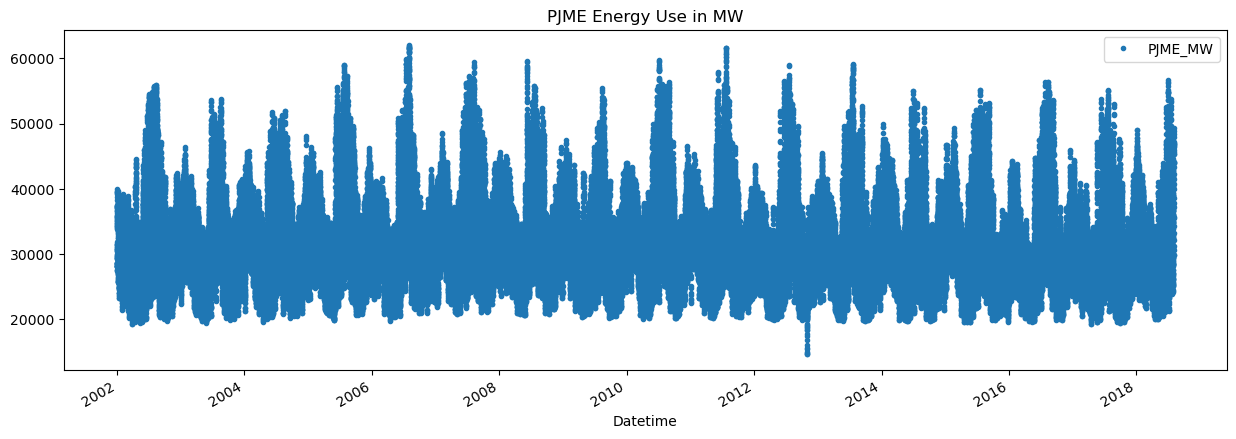

In [9]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Train Test Split

An easy train-test split for time series by date

In [10]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

In [11]:
train.shape

(113926, 1)

In [12]:
test.shape

(31440, 1)

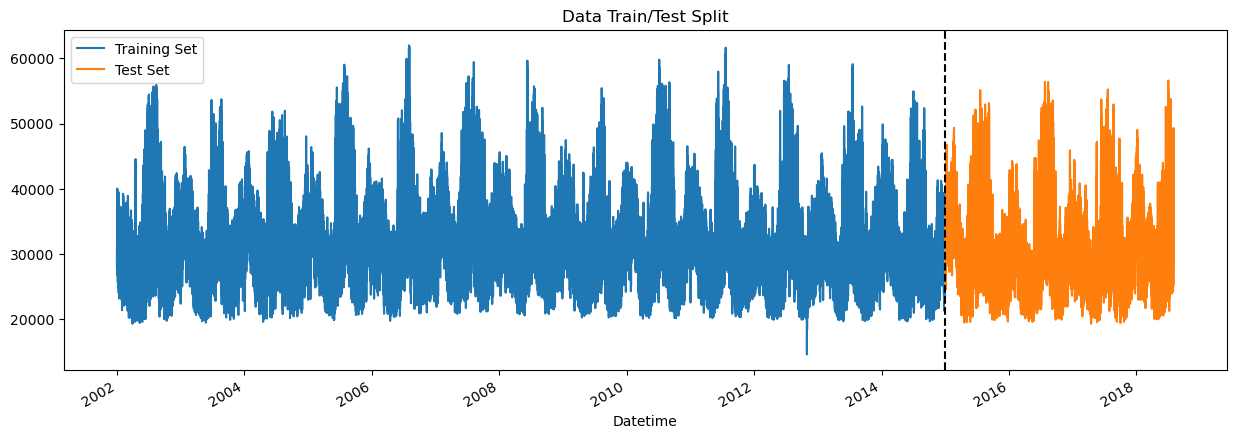

In [13]:
fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

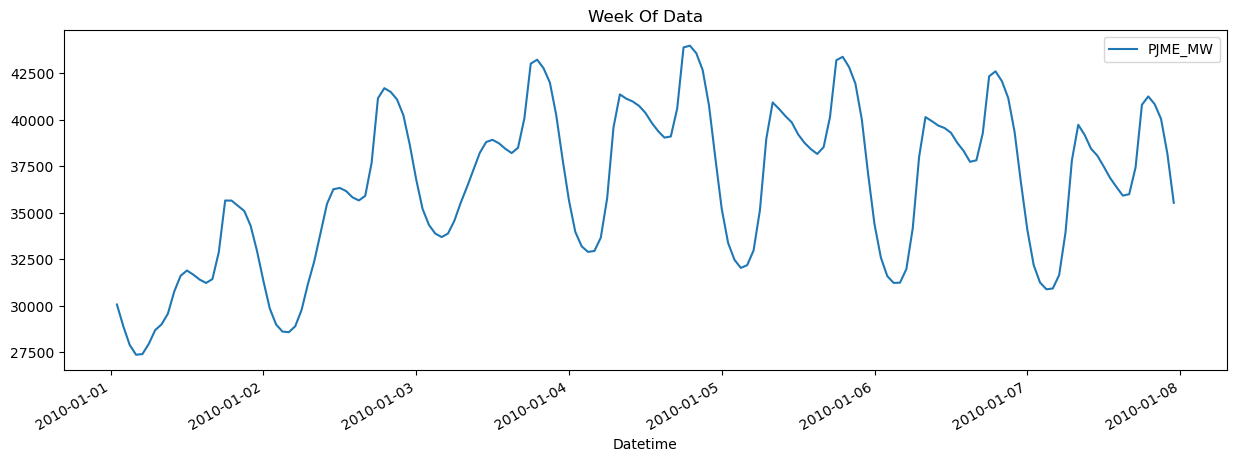

In [14]:
# How single week looks like
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
        .plot(figsize=(15,5), title='Week Of Data')
plt.show()

* Two different peaks during the day
* Decrease during the night
* The 1-st of January - is a Holiday

# Feature Creation

In [15]:
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

In [16]:
df = create_features(df)

In [17]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


# Visualize Feature / Target Relationship

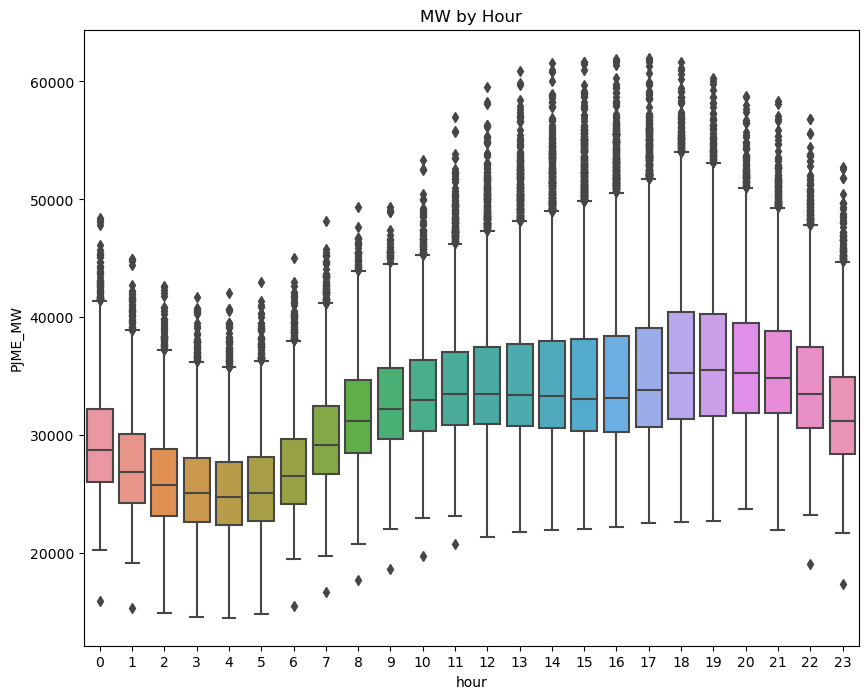

In [18]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='hour', y='PJME_MW')
ax.set_title('MW by Hour')
plt.show()

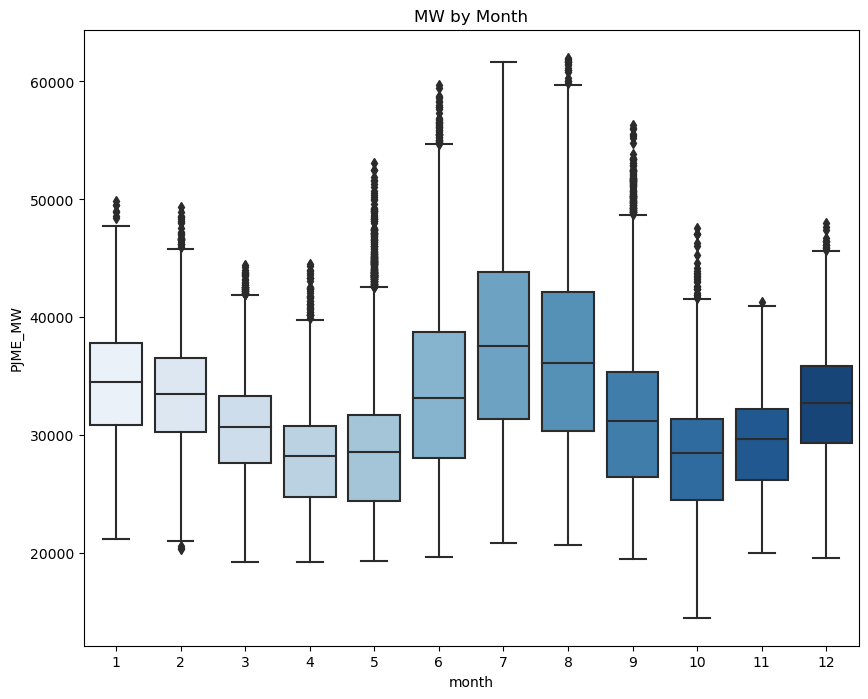

In [19]:
fig, ax = plt.subplots(figsize=(10,8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Create Model

In [20]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek', 'quarter', 'month', 'year', 'dayofyear']
TARGET = 'PJME_MW'

In [21]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [22]:
# # Overfitting
# reg = xgb.XGBRegressor(n_estimators=1000,
#                        early_stopping_rounds=50)
# reg.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         verbose=True)

In [23]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.001)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32894.63731	validation_1-rmse:31946.77347
[100]	validation_0-rmse:29802.40434	validation_1-rmse:28850.26822
[200]	validation_0-rmse:27007.68256	validation_1-rmse:26052.37585
[300]	validation_0-rmse:24482.32583	validation_1-rmse:23533.86101
[400]	validation_0-rmse:22201.28958	validation_1-rmse:21261.60426
[500]	validation_0-rmse:20141.56874	validation_1-rmse:19211.83146
[600]	validation_0-rmse:18281.67829	validation_1-rmse:17373.02835
[700]	validation_0-rmse:16603.55487	validation_1-rmse:15717.84372
[800]	validation_0-rmse:15090.25111	validation_1-rmse:14218.03651
[900]	validation_0-rmse:13726.70240	validation_1-rmse:12872.56965
[999]	validation_0-rmse:12510.66291	validation_1-rmse:11682.75145


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [24]:
reg = xgb.XGBRegressor(n_estimators=1000,
                       early_stopping_rounds=50,
                       learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[100]	validation_0-rmse:12342.17856	validation_1-rmse:11516.21767
[200]	validation_0-rmse:5373.20460	validation_1-rmse:5164.97392
[300]	validation_0-rmse:3375.48321	validation_1-rmse:3834.00707
[400]	validation_0-rmse:2884.85132	validation_1-rmse:3716.33146
[450]	validation_0-rmse:2771.93085	validation_1-rmse:3730.77469


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Freature Importance

In [25]:
fi = pd.DataFrame(data=reg.feature_importances_,
                  index=reg.feature_names_in_,
                  columns=['importance'])

In [26]:
fi.sort_values('importance', ascending=False)

,importance
hour,0.448804
month,0.228156
dayofweek,0.158668
dayofyear,0.108419
quarter,0.033319
year,0.022634


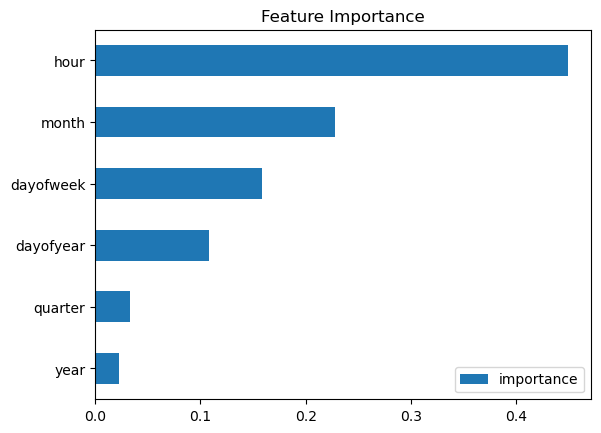

In [27]:
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

There is some overlap in the data. If we remove month, dayofyear would be on it's place

# Forecast on Test

In [28]:
test['prediction'] = reg.predict(X_test)

In [29]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,31861.591797
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,28268.078125
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,27164.314453
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26900.753906
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26900.753906


In [30]:
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

In [31]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,40829.566406
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,40358.277344
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,39135.480469
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,35866.378906
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,31363.611328


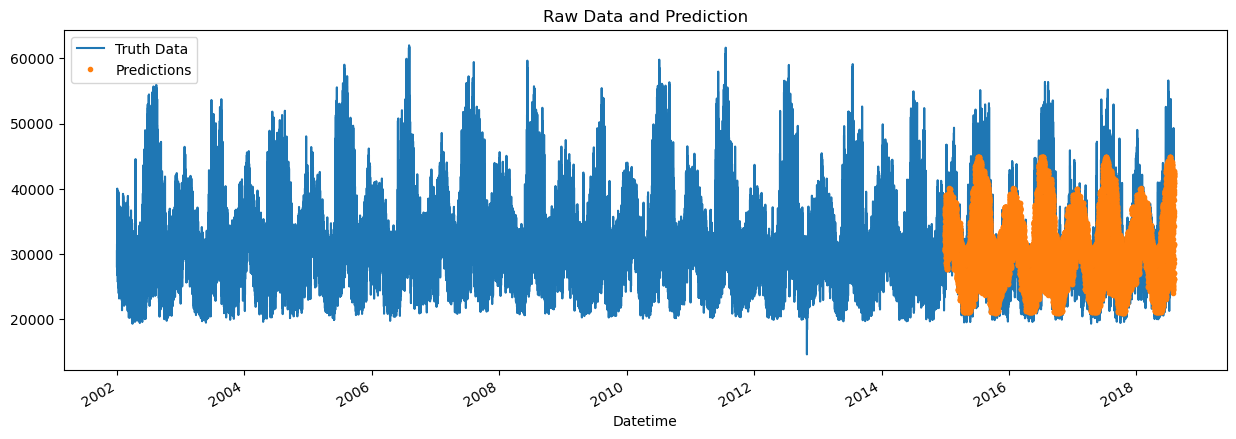

In [32]:
ax = df[['PJME_MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Prediction')
plt.show()

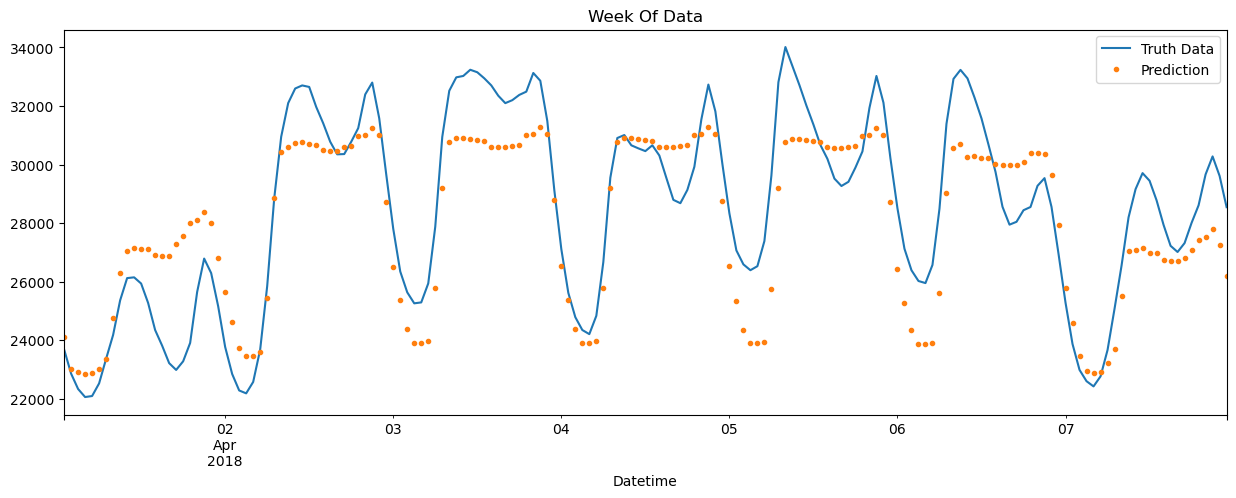

In [33]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
        .plot(figsize=(15,5), title='Week Of Data')
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
        .plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()

In [34]:
# Root Mean Squared Error - the same metric which is used in model training/validation
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on test set: {score:0.2f}')

RMSE Score on test set: 3715.93


# Calculate Error

* Let's look at the worst and best predicted days

In [35]:
test['error'] = np.abs(test[TARGET] - test['prediction'])

In [36]:
test.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,error
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,31861.591797,940.408203
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,28268.078125,3963.078125
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,27164.314453,4008.314453
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26900.753906,4386.753906
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26900.753906,4570.753906


In [37]:
test['date'] = test.index.date

In [38]:
# The worst predicted day
test.groupby('date')['error'].mean().sort_values(ascending=False).head(5)

date
2016-08-13    14577.210124
2016-08-14    14472.472738
2016-09-10    12494.880941
2016-08-12    11525.418376
2016-09-09    11369.640299
Name: error, dtype: float64

In [39]:
# The best predicted day
test.groupby('date')['error'].mean().sort_values(ascending=True).head(5)

date
2016-04-04    389.607829
2016-09-27    396.752116
2015-03-10    456.506510
2016-05-01    465.372640
2016-12-08    494.141764
Name: error, dtype: float64

We can try to improve worst predicted days

# Next Possible Steps ToDo

* More robust Cross Validation
* Add more features (weather forecast, holidays)

# 2. Time Series Forecasting with XGBoost - Advanced Methods

In [40]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error

color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [41]:
color_pal

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

# Outline

* Outlier analysis
* Forecasting horizon explained
* Time Series Cross Validation
* Lag Features
* Predicting the Future

In [42]:
df = pd.read_csv('../data/data_ts/hourly_energy_consumption/PJME_hourly.csv')
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

In [43]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


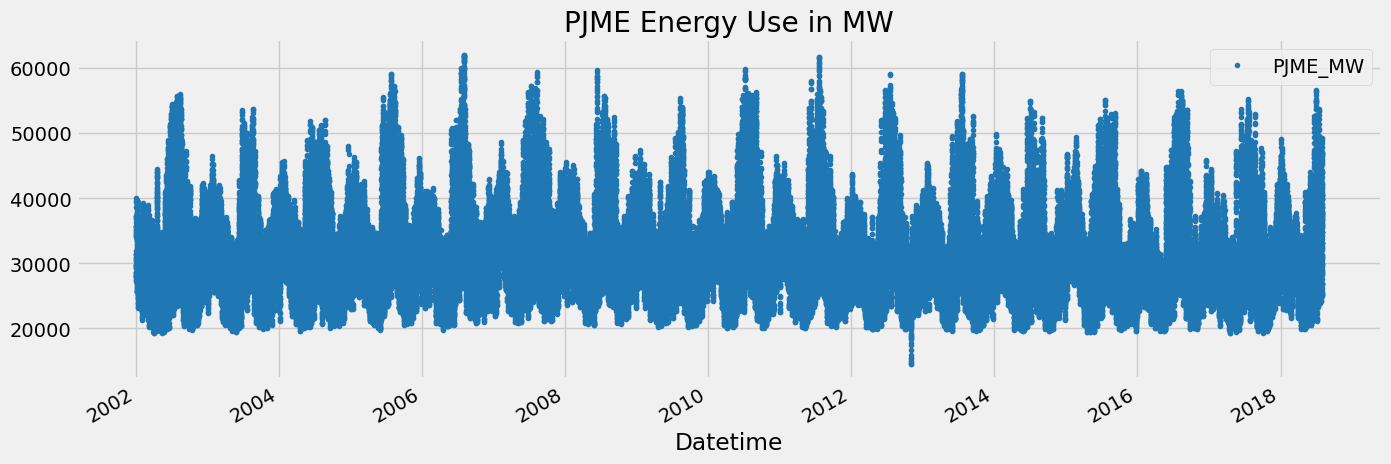

In [44]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Use in MW')
plt.show()

# Outlier Analysis and Removal

There are some points on the plot at the end of 2012 year, that seems to be outliers

<AxesSubplot:ylabel='Frequency'>

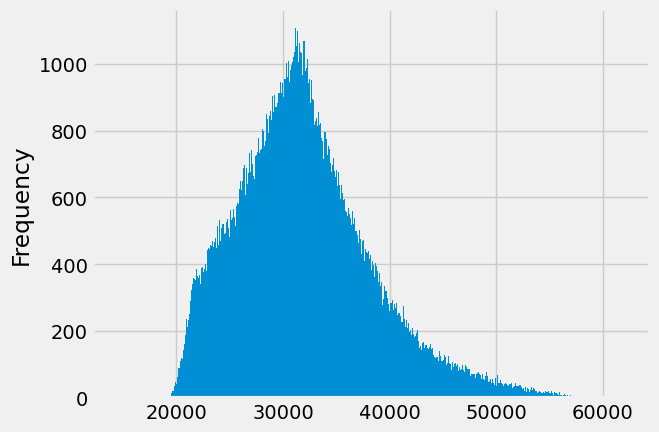

In [45]:
df['PJME_MW'].plot(kind='hist', bins=500)

In [46]:
df['PJME_MW'].shape

(145366,)

In [47]:
df.query('PJME_MW < 20_000')

,PJME_MW
Datetime,
2002-10-13 04:00:00,19854.0
2002-10-13 05:00:00,19702.0
2002-10-13 06:00:00,19936.0
2002-09-29 05:00:00,19950.0
2002-06-09 06:00:00,19954.0
...,...
2017-04-15 04:00:00,19820.0
2017-04-15 05:00:00,19994.0
2018-05-06 05:00:00,19937.0


<AxesSubplot:xlabel='Datetime'>

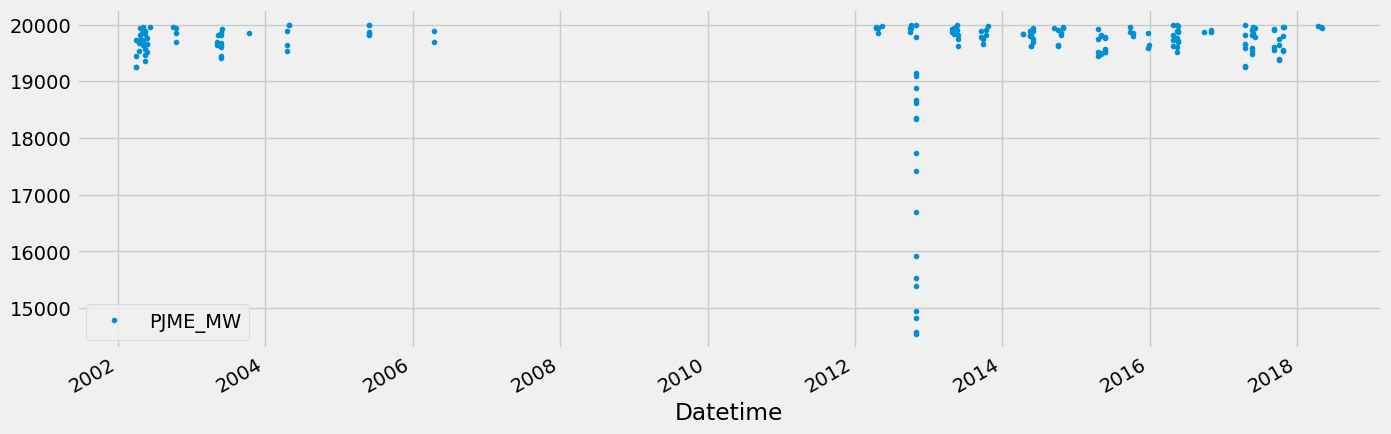

In [48]:
df.query('PJME_MW < 20_000').plot(figsize=(15,5), style='.')

<AxesSubplot:title={'center':'Outliers'}, xlabel='Datetime'>

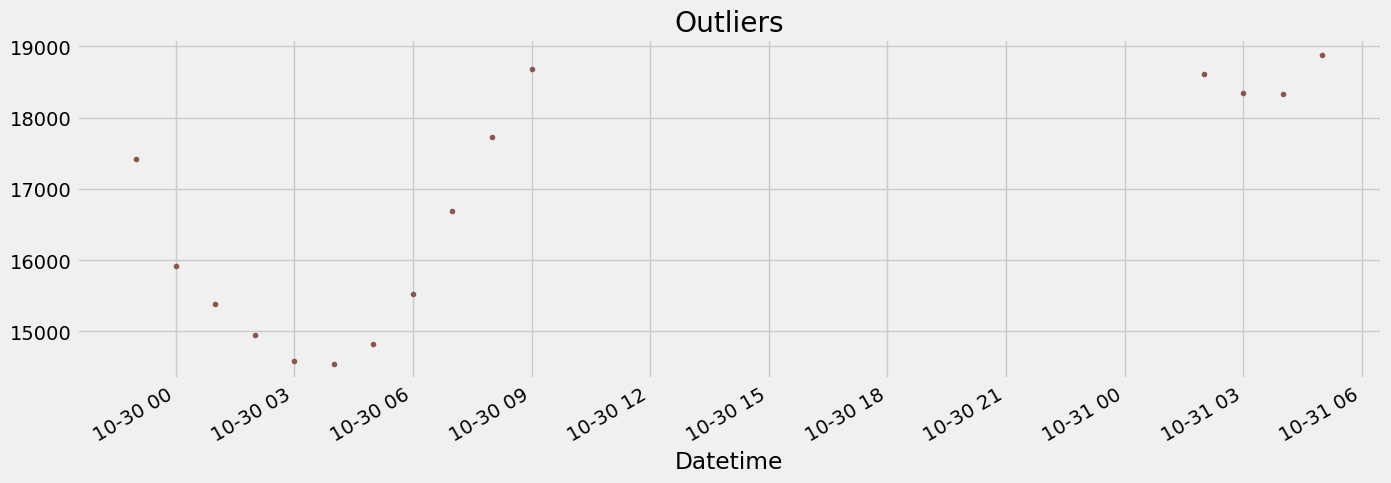

In [49]:
df.query('PJME_MW < 19_000')['PJME_MW'] \
    .plot(figsize=(15,5),
          style='.',
          color=color_pal[5],
          title='Outliers')

* The way of removal of outliers, just to delete
* We can also use some statistics to fill the outliers

In [50]:
df = df.query('PJME_MW > 19_000').copy()

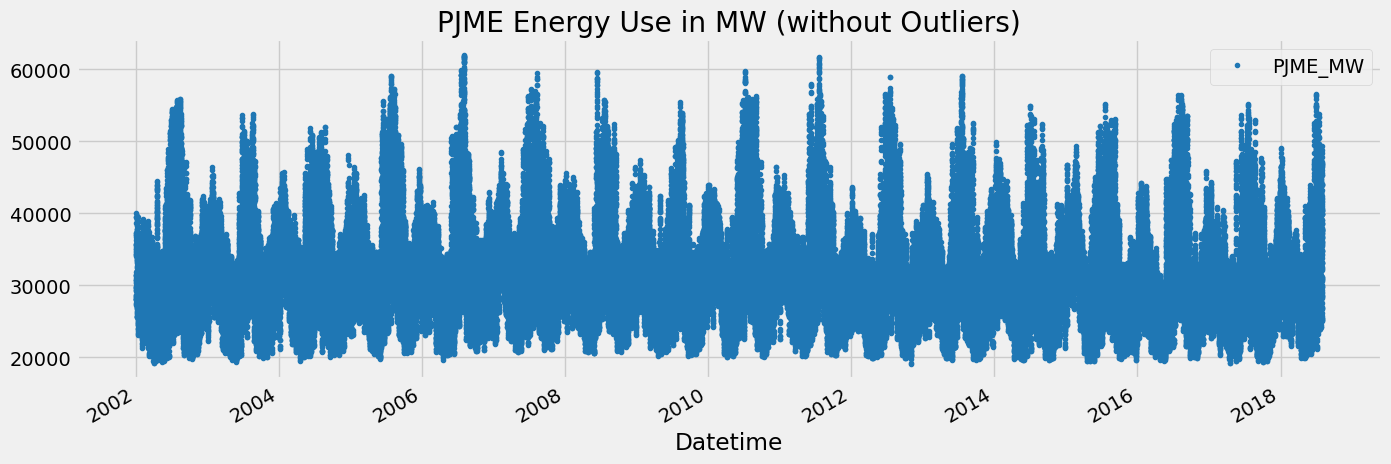

In [51]:
df.plot(style='.',
        figsize=(15,5),
        color=color_pal[0],
        title='PJME Energy Use in MW (without Outliers)')
plt.show()

# Reviewing: Train Test Split

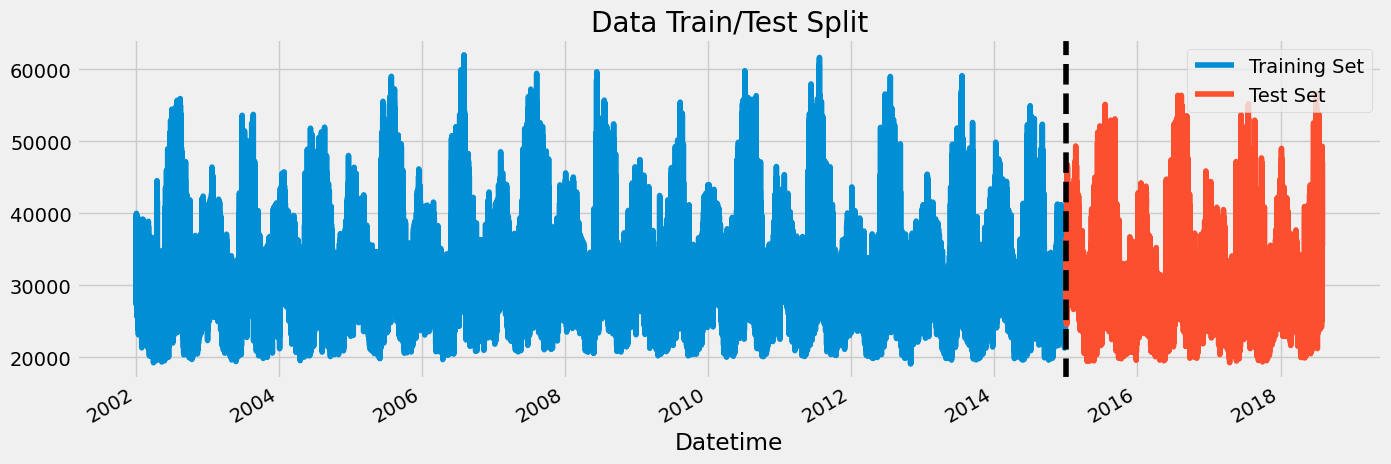

In [52]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize=(15,5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.axvline('01-01-2015', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

Better to use Cross Validation for more Robust Model

# Time Series Cross Validation

In [53]:
from sklearn.model_selection import TimeSeriesSplit

In [54]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

In [55]:
# tss is a generator
tss

TimeSeriesSplit(gap=24, max_train_size=None, n_splits=5, test_size=8760)

In [56]:
for train_idx, val_idx in tss.split(df):
    break

In [57]:
train_idx

array([     0,      1,      2, ..., 101524, 101525, 101526])

In [58]:
val_idx

array([101551, 101552, 101553, ..., 110308, 110309, 110310])

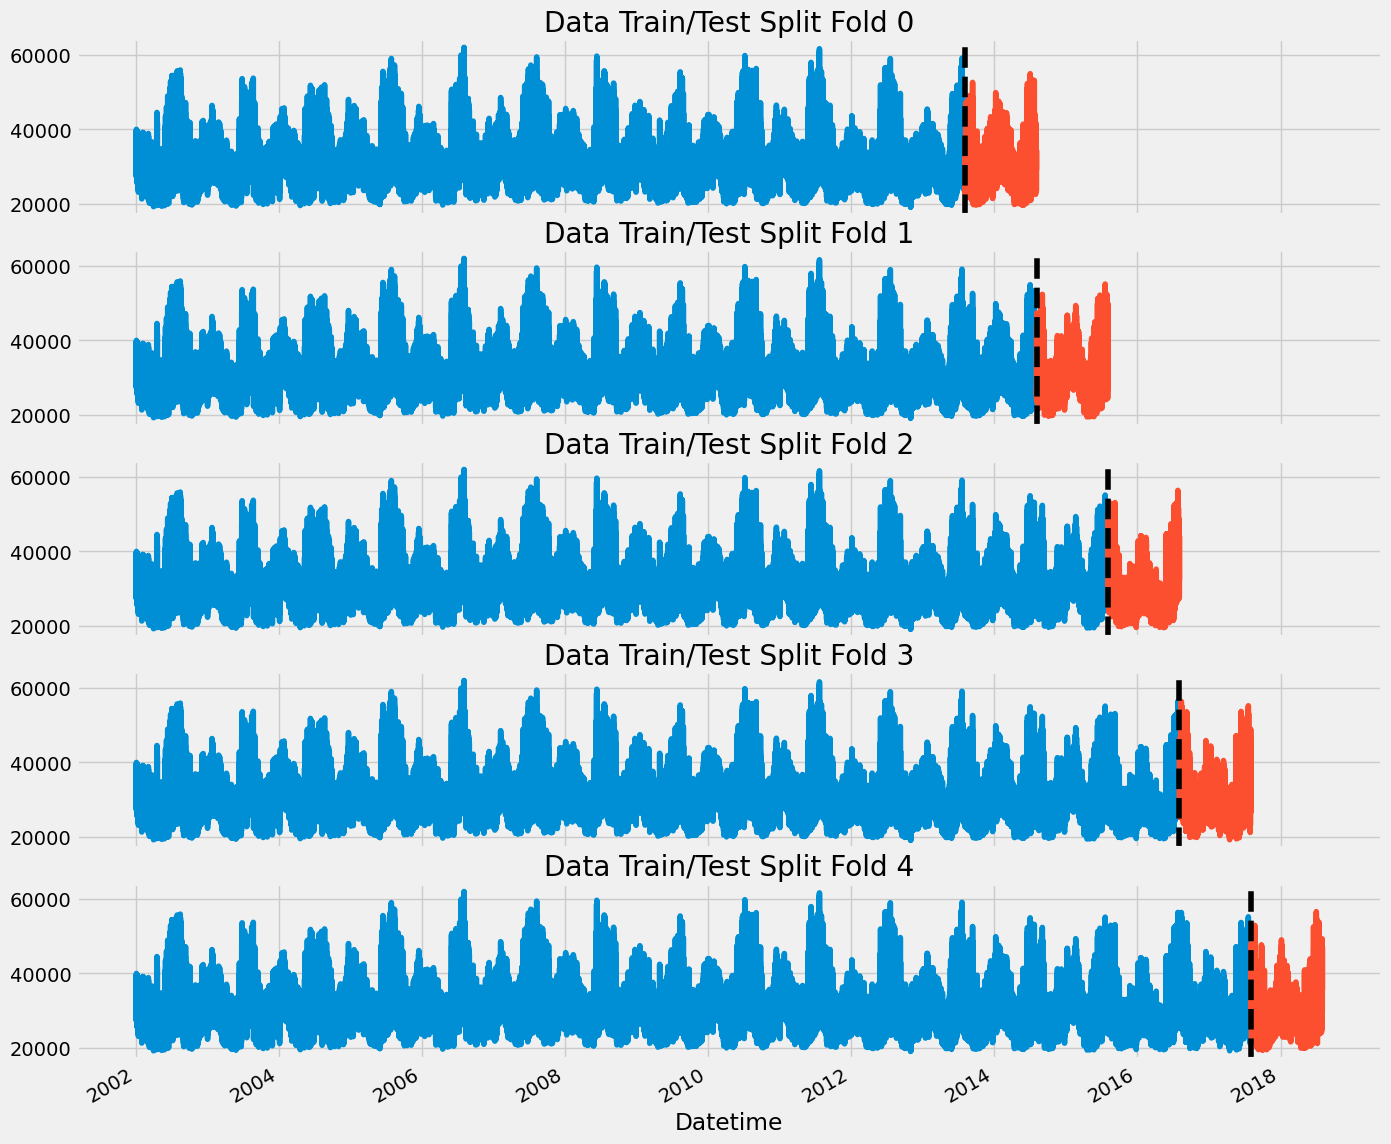

In [59]:
fig, axs = plt.subplots(5, 1, figsize=(15,15),
                        sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train['PJME_MW'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['PJME_MW'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    
    fold += 1

# Forecasting Horizon Explained

The forecast horizon is the length of time into the future for which forecasts are to be prepared. These generally vary from short-term forecasting hirizons (less than three months) to long-term horizons (more that two years)

In [60]:
# Beforehead let's add time series features to dataset
def create_features(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

In [61]:
df = create_features(df)

# Lag Freatures

* What was the target (x) days in the past

In [62]:
def add_lags(df):
    df = df.copy()
    target_map = df['PJME_MW'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('364 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('728 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('1092 days')).map(target_map)
    return df

In [63]:
df = add_lags(df)

In [64]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN


In [65]:
df.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3
Datetime,,,,,,,,,,,,
2018-08-02 20:00:00,44057.0,20,3,3,8,2018,214,2,31,42256.0,41485.0,38804.0
2018-08-02 21:00:00,43256.0,21,3,3,8,2018,214,2,31,41210.0,40249.0,38748.0
2018-08-02 22:00:00,41552.0,22,3,3,8,2018,214,2,31,39525.0,38698.0,37330.0
2018-08-02 23:00:00,38500.0,23,3,3,8,2018,214,2,31,36490.0,35406.0,34552.0
2018-08-03 00:00:00,35486.0,0,4,3,8,2018,215,3,31,33539.0,32094.0,31695.0


## Train Using Cross Validation

In [66]:
tss = TimeSeriesSplit(n_splits=5, test_size=24*365*1, gap=24)
df = df.sort_index()

preds = []
scores = []

for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    
    train = create_features(train)
    test = create_features(test)
    
    FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
                'lag1', 'lag2', 'lag3']
    TARGET = 'PJME_MW'
    
    X_train = train[FEATURES]
    y_train = train[TARGET]
    
    X_test = test[FEATURES]
    y_test = test[TARGET]
    
    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)
    
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[12:39:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32732.50147	validation_1-rmse:31956.66494
[100]	validation_0-rmse:12532.10915	validation_1-rmse:11906.70125
[200]	validation_0-rmse:5739.78666	validation_1-rmse:5352.86754
[300]	validation_0-rmse:3868.29390	validation_1-rmse:3891.32148
[400]	validation_0-rmse:3428.85875	validation_1-rmse:3753.95996
[456]	validation_0-rmse:3349.18480	validation_1-rmse:3761.64093
[12:39:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32672.16154	validation_1-rmse:32138.88680
[100]	validation_0-rmse:12513.25338	validation_1-rmse:12222.97626
[200]	validation_0-rms

In [67]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 3750.6406
Fold scores:[3753.2775219986684, 3434.3528874818867, 3475.9138463312997, 4093.3608331481823, 3996.298054855067]


# Predicting the Future

* Retraining on all data
* To Predict the future we need an empty dataframe for future date ranges
* Run those dates through our feature creation code + lag creation

In [68]:
# Retrain on all data
df = create_features(df)

FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year',
            'lag1', 'lag2', 'lag3']
TARGET = 'PJME_MW'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',
                       n_estimators=500,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)

reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[12:40:36] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:32403.88753
[100]	validation_0-rmse:12426.44700
[200]	validation_0-rmse:5752.69704
[300]	validation_0-rmse:3970.08787
[400]	validation_0-rmse:3569.37848
[499]	validation_0-rmse:3454.55122


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             objective='reg:linear', predictor=None, ...)

In [69]:
df.index.max()

Timestamp('2018-08-03 00:00:00')

In [70]:
# Create future dataframe
future = pd.date_range('2018-08-03', '2019-08-01', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df,future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

In [71]:
df_and_future.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2002-01-01 01:00:00,30393.0,1,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 02:00:00,29265.0,2,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 03:00:00,28357.0,3,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 04:00:00,27899.0,4,1,1,1,2002,1,1,1,NaN,NaN,NaN,False
2002-01-01 05:00:00,28057.0,5,1,1,1,2002,1,1,1,NaN,NaN,NaN,False


In [72]:
df_and_future.tail()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,lag1,lag2,lag3,isFuture
2019-07-31 20:00:00,NaN,20,2,3,7,2019,212,31,31,46912.0,39352.0,40243.0,True
2019-07-31 21:00:00,NaN,21,2,3,7,2019,212,31,31,45985.0,38699.0,39183.0,True
2019-07-31 22:00:00,NaN,22,2,3,7,2019,212,31,31,44094.0,37346.0,37759.0,True
2019-07-31 23:00:00,NaN,23,2,3,7,2019,212,31,31,40666.0,34555.0,34641.0,True
2019-08-01 00:00:00,NaN,0,3,3,8,2019,213,1,31,37158.0,31646.0,31470.0,True


In [73]:
future_with_features = df_and_future.query('isFuture').copy()

# Prediction

In [74]:
future_with_features['pred'] = reg.predict(future_with_features[FEATURES])

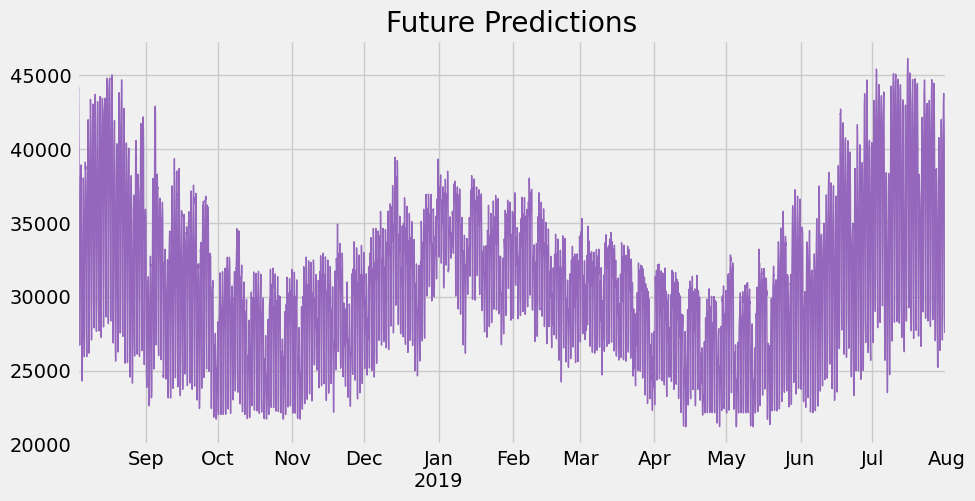

In [75]:
future_with_features['pred'].plot(figsize=(10,5),
                                  color=color_pal[4],
                                  ms=1,
                                  lw=1,
                                  title='Future Predictions')
plt.show()

# 3. Forecasting with Facebook Prophet Model

Prophet Forecasting Model Equation

y(t) = g(t) + h(t) + s(t) + et

* y(t) - additive regressive model
* g(t) - trend factor
* h(t) - holiday component
* s(t) - seasonality component
* et - error term

In [76]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore')

In [77]:
plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

In [78]:
from sklearn.metrics import mean_absolute_percentage_error

In [79]:
def custom_mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [80]:
from pandas.api.types import CategoricalDtype

# Data

The data we will be using is hourly power consumption data from PJM. Energy consumption has some unique characteristics. It will be interesting to see how prophet picks them up.

Pulling the PJM East which has data from 2002-2018 for the entire east region

In [81]:
df = pd.read_csv('../data/data_ts/hourly_energy_consumption/PJME_hourly.csv',
                 index_col=[0],
                 parse_dates=[0])

In [82]:
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [83]:
color_pal = sns.color_palette()

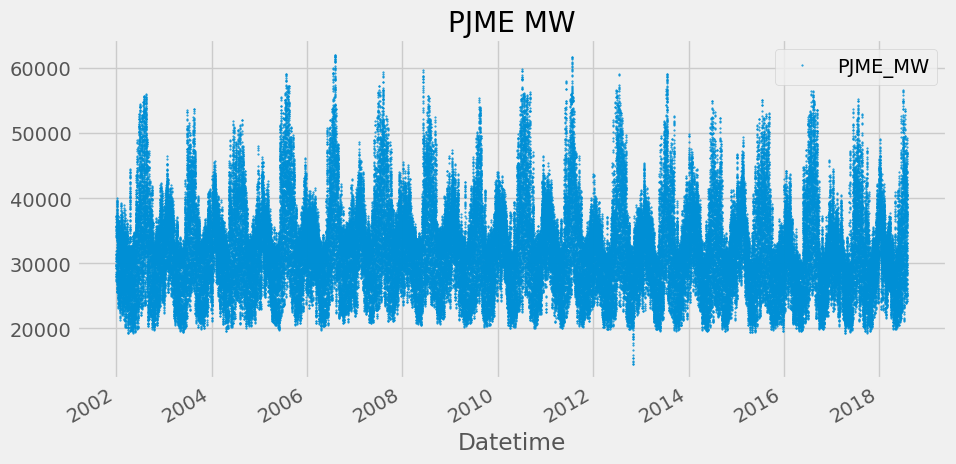

In [84]:
df.plot(style='.',
        figsize=(10,5),
        ms=1,
        color=color_pal[0],
        title='PJME MW')
plt.show()

# Time Series Features

These features are created in order to visualize the data

In [85]:
cat_type = CategoricalDtype(categories=['Monday', 'Tuesday',
                                        'Wednesday',
                                        'Thursday', 'Friday',
                                        'Saturday', 'Sunday'],
                            ordered=True)

In [86]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320) % 1300
    
    df['season'] = pd.cut(df['date_offset'],
                          [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    
    X = df[['hour', 'dayofweek', 'quarter', 'month', 'year',
            'dayofyear', 'dayofmonth', 'weekofyear', 'weekday',
            'season']]
    
    if label:
        y = df[label]
        return X, y
    return X

In [87]:
X, y = create_features(df, label='PJME_MW')

In [88]:
features_and_target = pd.concat([X, y], axis=1)

In [89]:
df.shape, X.shape, y.shape

((145366, 1), (145366, 10), (145366,))

In [90]:
X[X['season'] == 'Winter'].head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season
Datetime,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter


In [91]:
X[X['season'] == 'Spring'].head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season
Datetime,,,,,,,,,,
2002-06-20 01:00:00,1,3,2,6,2002,171,20,25,Thursday,Spring
2002-06-20 02:00:00,2,3,2,6,2002,171,20,25,Thursday,Spring
2002-06-20 03:00:00,3,3,2,6,2002,171,20,25,Thursday,Spring
2002-06-20 04:00:00,4,3,2,6,2002,171,20,25,Thursday,Spring
2002-06-20 05:00:00,5,3,2,6,2002,171,20,25,Thursday,Spring


In [92]:
X[X['season'] == 'Summer'].head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season
Datetime,,,,,,,,,,
2002-09-22 01:00:00,1,6,3,9,2002,265,22,38,Sunday,Summer
2002-09-22 02:00:00,2,6,3,9,2002,265,22,38,Sunday,Summer
2002-09-22 03:00:00,3,6,3,9,2002,265,22,38,Sunday,Summer
2002-09-22 04:00:00,4,6,3,9,2002,265,22,38,Sunday,Summer
2002-09-22 05:00:00,5,6,3,9,2002,265,22,38,Sunday,Summer


In [93]:
X[X['season'] == 'Fall'].head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season
Datetime,,,,,,,,,,
2002-12-20 01:00:00,1,4,4,12,2002,354,20,51,Friday,Fall
2002-12-20 02:00:00,2,4,4,12,2002,354,20,51,Friday,Fall
2002-12-20 03:00:00,3,4,4,12,2002,354,20,51,Friday,Fall
2002-12-20 04:00:00,4,4,4,12,2002,354,20,51,Friday,Fall
2002-12-20 05:00:00,5,4,4,12,2002,354,20,51,Friday,Fall


In [94]:
X[X['season'].isna()]

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season
Datetime,,,,,,,,,,
2002-03-20 01:00:00,1,2,1,3,2002,79,20,12,Wednesday,NaN
2002-03-20 02:00:00,2,2,1,3,2002,79,20,12,Wednesday,NaN
2002-03-20 03:00:00,3,2,1,3,2002,79,20,12,Wednesday,NaN
2002-03-20 04:00:00,4,2,1,3,2002,79,20,12,Wednesday,NaN
2002-03-20 05:00:00,5,2,1,3,2002,79,20,12,Wednesday,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-03-20 20:00:00,20,1,1,3,2018,79,20,12,Tuesday,NaN
2018-03-20 21:00:00,21,1,1,3,2018,79,20,12,Tuesday,NaN
2018-03-20 22:00:00,22,1,1,3,2018,79,20,12,Tuesday,NaN


In [95]:
features_and_target.head()

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,weekday,season,PJME_MW
Datetime,,,,,,,,,,,
2002-12-31 01:00:00,1,1,4,12,2002,365,31,1,Tuesday,Winter,26498.0
2002-12-31 02:00:00,2,1,4,12,2002,365,31,1,Tuesday,Winter,25147.0
2002-12-31 03:00:00,3,1,4,12,2002,365,31,1,Tuesday,Winter,24574.0
2002-12-31 04:00:00,4,1,4,12,2002,365,31,1,Tuesday,Winter,24393.0
2002-12-31 05:00:00,5,1,4,12,2002,365,31,1,Tuesday,Winter,24860.0


In [96]:
features_and_target.isna().sum()

hour            0
dayofweek       0
quarter         0
month           0
year            0
dayofyear       0
dayofmonth      0
weekofyear      0
weekday         0
season        408
PJME_MW         0
dtype: int64

Seasons could be split BETTER!

In [97]:
features_and_target['season_well'] = 'Winter'
features_and_target.loc[features_and_target['month'].isin([3,4,5]), 'season_well'] = 'Spring'
features_and_target.loc[features_and_target['month'].isin([6,7,8]), 'season_well'] = 'Summer'
features_and_target.loc[features_and_target['month'].isin([9,10,11]), 'season_well'] = 'Fall'

In [98]:
features_and_target.isna().sum()

hour             0
dayofweek        0
quarter          0
month            0
year             0
dayofyear        0
dayofmonth       0
weekofyear       0
weekday          0
season         408
PJME_MW          0
season_well      0
dtype: int64

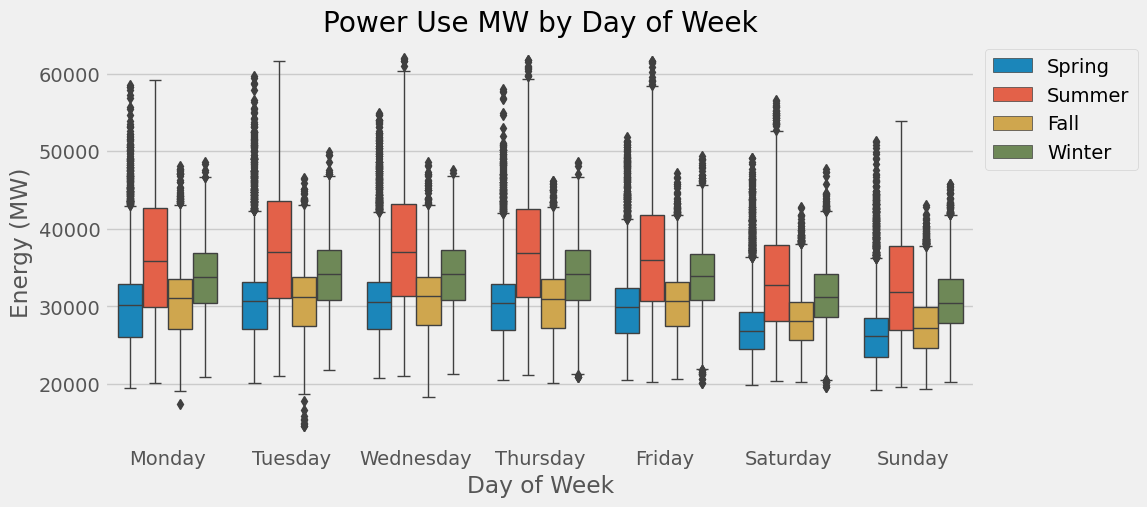

In [99]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='PJME_MW',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

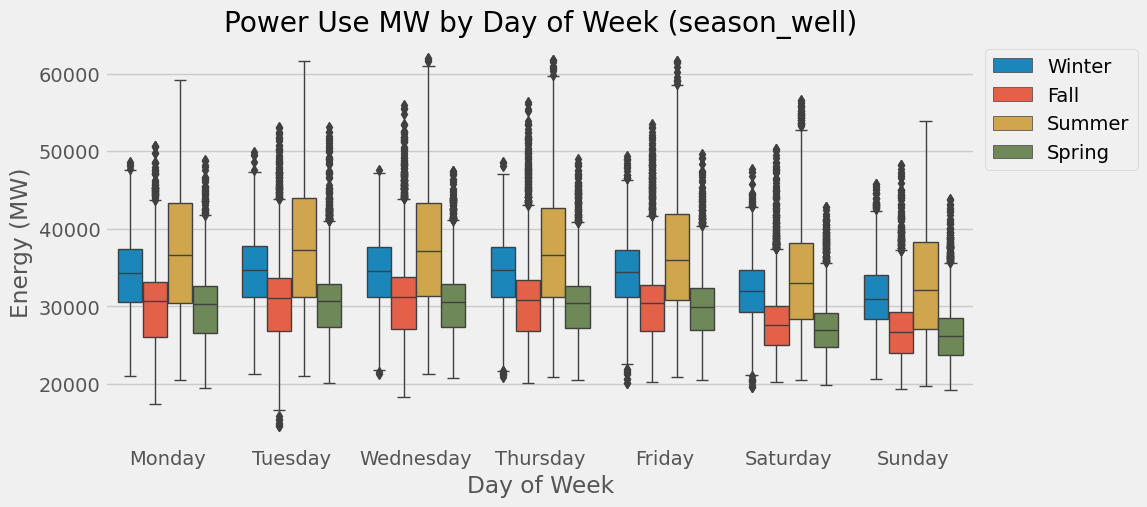

In [100]:
fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(data=features_and_target,
            x='weekday',
            y='PJME_MW',
            hue='season_well',
            ax=ax,
            linewidth=1)
ax.set_title('Power Use MW by Day of Week (season_well)')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Energy (MW)')
ax.legend(bbox_to_anchor=(1,1))
plt.show()

We have peaks in Winter and Summer

# Train Test Split

Just basic Train Test Split for fast exploration of model

In [101]:
split_date = '1-Jan-2015'
df_train = df.loc[df.index <= split_date].copy()
df_test = df.loc[df.index > split_date].copy()

In [102]:
df_train.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


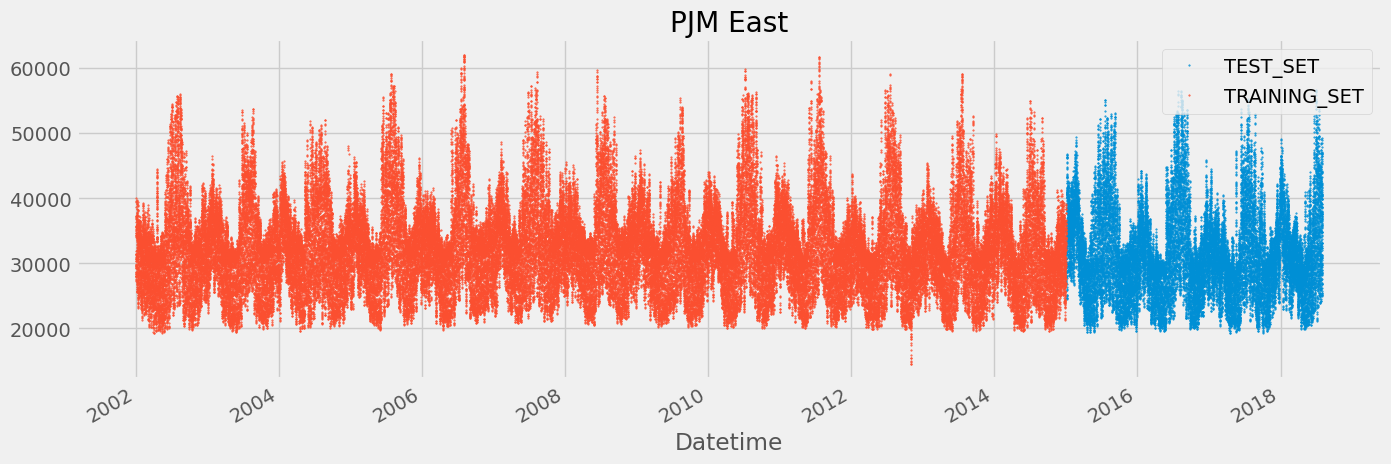

In [103]:
df_test \
    .rename(columns={'PJME_MW': 'TEST_SET'}) \
    .join(df_train.rename(columns={'PJME_MW': 'TRAINING_SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='PJM East', style='.', ms=1)
plt.show()

# Simple Prophet Model

Prophet model expects the dataset to be named a specific way:
* Datetime column named: <b>ds</b>
* target: <b>y</b>

In [104]:
# Format data for prophet model using ds and y
df_train_prophet = df_train.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

In [105]:
df_train_prophet.head()

,ds,y
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [106]:
%%time
model = Prophet()
model.fit(df_train_prophet)

12:45:04 - cmdstanpy - INFO - Chain [1] start processing
12:46:32 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 1min 40s


In [107]:
df_train_prophet.shape

(113927, 2)

In [108]:
# Predict on test set with model
df_test_prophet = df_test.reset_index() \
    .rename(columns={'Datetime': 'ds',
                     'PJME_MW': 'y'})

df_test_fcst = model.predict(df_test_prophet)

In [109]:
df_test_prophet.shape

(31439, 2)

In [110]:
df_test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31203.428443,24334.150721,33195.501191,31203.428443,31203.428443,-2845.249382,-2845.249382,-2845.249382,-4430.355857,-4430.355857,-4430.355857,1281.388794,1281.388794,1281.388794,303.717681,303.717681,303.717681,0.0,0.0,0.0,28358.179061
1,2015-01-01 02:00:00,31203.390393,22590.748528,31386.380173,31203.390393,31203.390393,-4349.694004,-4349.694004,-4349.694004,-5927.332380,-5927.332380,-5927.332380,1272.625061,1272.625061,1272.625061,305.013315,305.013315,305.013315,0.0,0.0,0.0,26853.696389
2,2015-01-01 03:00:00,31203.352343,21257.536821,30559.458671,31203.352343,31203.352343,-5221.371965,-5221.371965,-5221.371965,-6790.378010,-6790.378010,-6790.378010,1262.655592,1262.655592,1262.655592,306.350452,306.350452,306.350452,0.0,0.0,0.0,25981.980378
3,2015-01-01 04:00:00,31203.314293,21290.771669,30320.091095,31203.314293,31203.314293,-5362.820050,-5362.820050,-5362.820050,-6922.153232,-6922.153232,-6922.153232,1251.604062,1251.604062,1251.604062,307.729120,307.729120,307.729120,0.0,0.0,0.0,25840.494243
4,2015-01-01 05:00:00,31203.276243,22014.963398,30630.064964,31203.276243,31203.276243,-4688.373560,-4688.373560,-4688.373560,-6237.129258,-6237.129258,-6237.129258,1239.606356,1239.606356,1239.606356,309.149342,309.149342,309.149342,0.0,0.0,0.0,26514.902682


Prophet - is an additive model. It shows each component of the prediction
* yhat - is the predicted value

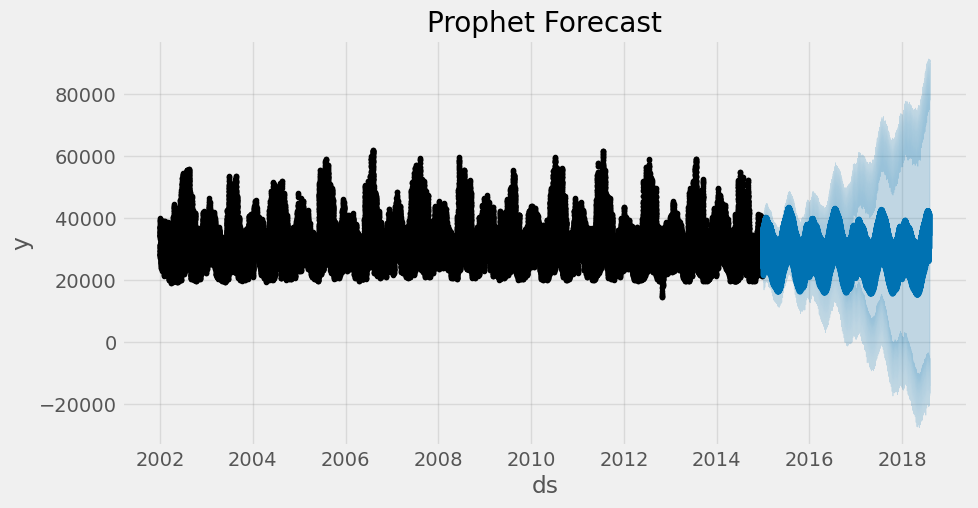

In [111]:
# prophet goes with visualization included
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(df_test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()

* darker blue - forcasted values
* and light confidence intervals

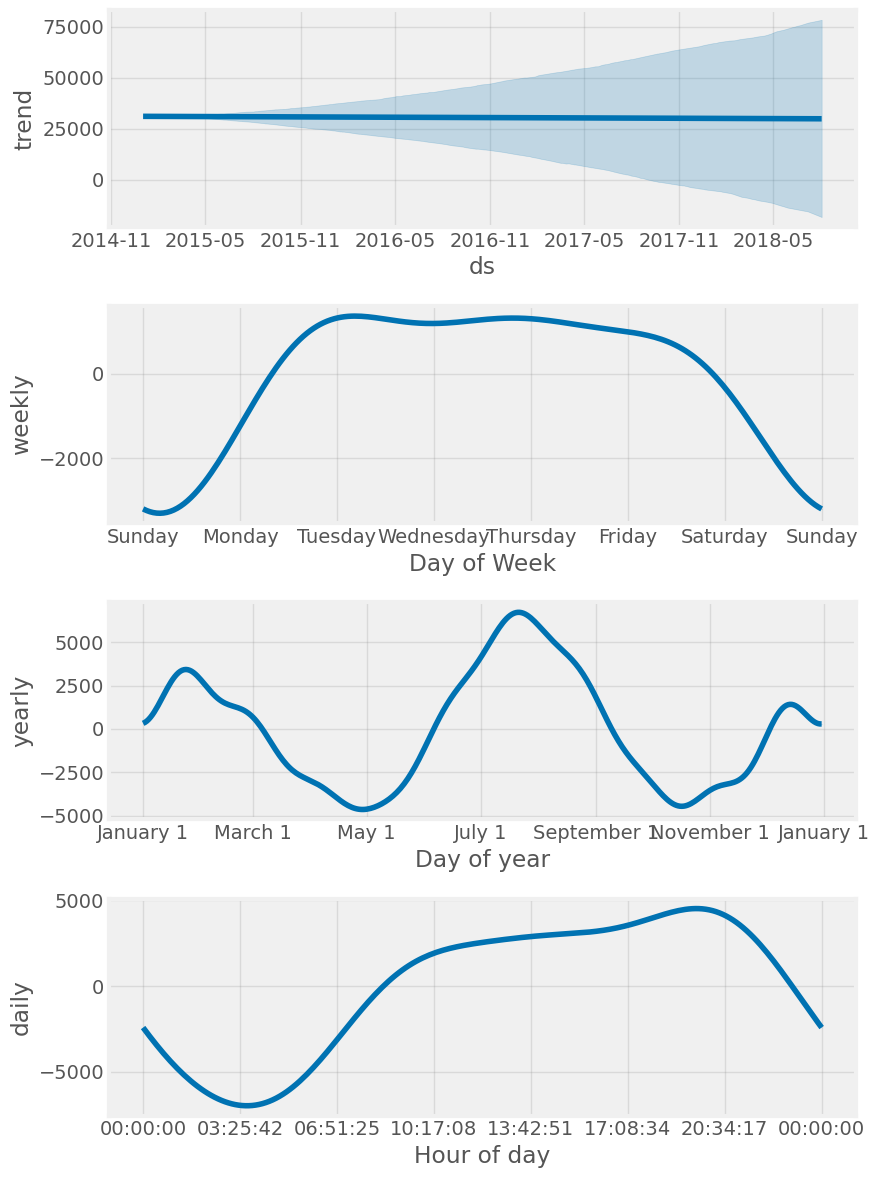

In [112]:
# plot the components
fig = model.plot_components(df_test_fcst)
plt.show()

# Compare Forecast to Actuals

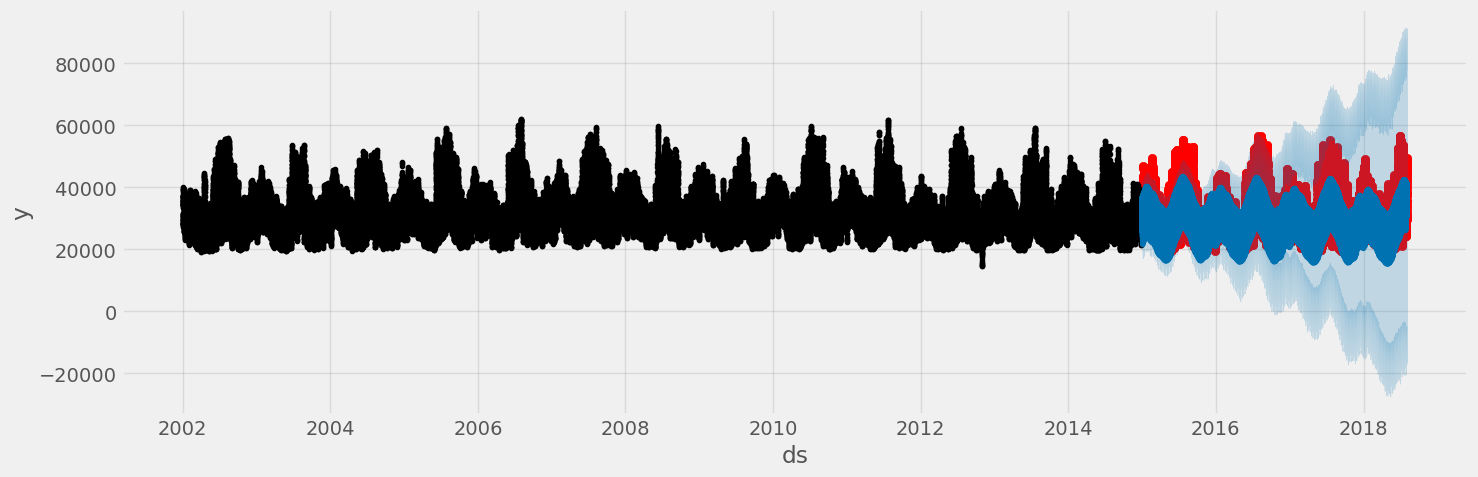

In [113]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15,5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(df_test_fcst, ax=ax)

Predictions are lower than the actual values

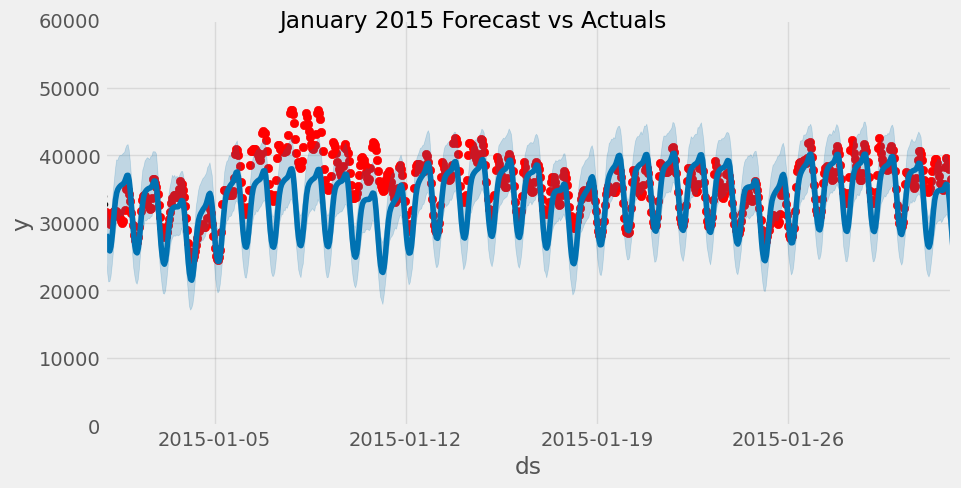

In [114]:
# Zoom into the first predicted month
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015',
              upper='02-01-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('January 2015 Forecast vs Actuals')
plt.show()

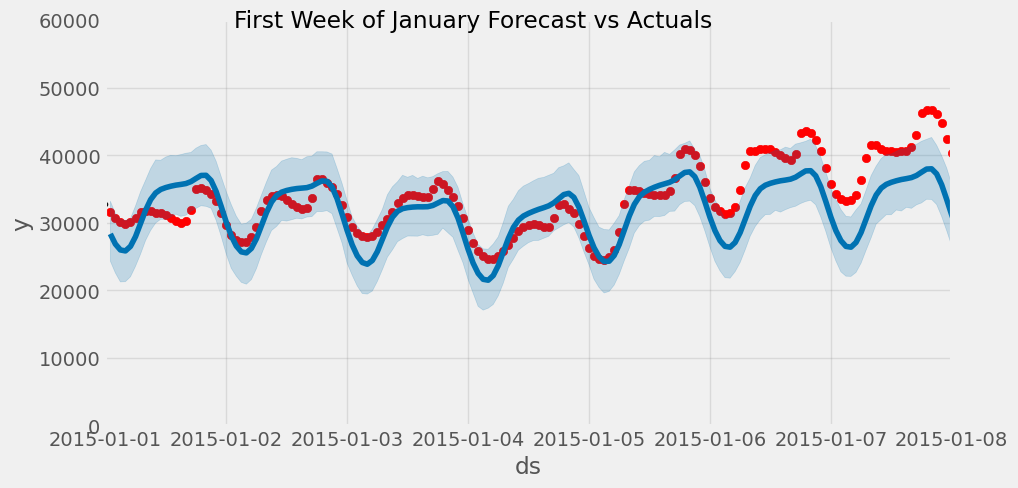

In [115]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2015',
              upper='01-08-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('First Week of January Forecast vs Actuals')
plt.show()

# Evaluate the model with Error Metrics

In [116]:
# root mean squared error
np.sqrt(mean_squared_error(y_true=df_test['PJME_MW'],
                           y_pred=df_test_fcst['yhat']))

6617.868136902021

This is worse than in XGBoost model

In [117]:
mean_absolute_error(y_true=df_test['PJME_MW'],
                    y_pred=df_test_fcst['yhat'])

5182.793987435977

In [118]:
custom_mean_absolute_percentage_error(y_true=df_test['PJME_MW'],
                                      y_pred=df_test_fcst['yhat'])

16.506586588257765

In [119]:
# The same but needed to be multiplied by 100
mean_absolute_percentage_error(y_true=df_test['PJME_MW'],
                               y_pred=df_test_fcst['yhat'])

0.16506586588257766

# Adding Holidays

Phophet has build in ability to indluce holidays

In [120]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [121]:
cal = calendar()

holidays = cal.holidays(start=df.index.min(),
                        end=df.index.max(),
                        return_name=True)
holidays_df = pd.DataFrame(data=holidays,
                           columns=['holiday_name']) \
    .assign(holiday='USFederalHoliday')

In [122]:
holidays_df.head()

,holiday_name,holiday
2002-01-21,"Birthday of Martin Luther King, Jr.",USFederalHoliday
2002-02-18,Washington’s Birthday,USFederalHoliday
2002-05-27,Memorial Day,USFederalHoliday
2002-07-04,Independence Day,USFederalHoliday
2002-09-02,Labor Day,USFederalHoliday


In [123]:
holidays_df['holiday_name'].value_counts(dropna=False)

Birthday of Martin Luther King, Jr.    17
Washington’s Birthday                  17
Memorial Day                           17
Independence Day                       17
Labor Day                              16
Columbus Day                           16
Veterans Day                           16
Thanksgiving Day                       16
Christmas Day                          16
New Year's Day                         16
Name: holiday_name, dtype: int64

In [124]:
holidays_df = holidays_df[['holiday_name']].reset_index() \
                .rename(columns={'index': 'ds',
                                 'holiday_name': 'holiday'})

In [125]:
holidays_df.head()

,ds,holiday
0,2002-01-21,"Birthday of Martin Luther King, Jr."
1,2002-02-18,Washington’s Birthday
2,2002-05-27,Memorial Day
3,2002-07-04,Independence Day
4,2002-09-02,Labor Day


In [126]:
%%time
model_with_holidays = Prophet(holidays=holidays_df)
model_with_holidays.fit(df_train_prophet)

12:49:48 - cmdstanpy - INFO - Chain [1] start processing
12:51:20 - cmdstanpy - INFO - Chain [1] done processing


Wall time: 1min 45s


In [127]:
df_test_fcst_with_holidays = model_with_holidays.predict(df=df_test_prophet)

In [128]:
df_test_fcst_with_holidays.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,"Birthday of Martin Luther King, Jr.","Birthday of Martin Luther King, Jr._lower","Birthday of Martin Luther King, Jr._upper",Christmas Day,Christmas Day_lower,Christmas Day_upper,Columbus Day,Columbus Day_lower,Columbus Day_upper,Independence Day,Independence Day_lower,Independence Day_upper,Labor Day,Labor Day_lower,Labor Day_upper,Memorial Day,Memorial Day_lower,Memorial Day_upper,New Year's Day,New Year's Day_lower,New Year's Day_upper,Thanksgiving Day,Thanksgiving Day_lower,Thanksgiving Day_upper,Veterans Day,Veterans Day_lower,Veterans Day_upper,Washington’s Birthday,Washington’s Birthday_lower,Washington’s Birthday_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-01 01:00:00,31249.001364,20881.237917,30258.213560,31249.001364,31249.001364,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3254.312932,-3254.312932,-3254.312932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-5715.845509,-5715.845509,-5715.845509,-4430.271457,-4430.271457,-4430.271457,-3254.312932,-3254.312932,-3254.312932,1324.589517,1324.589517,1324.589517,644.149363,644.149363,644.149363,0.0,0.0,0.0,25533.155856
1,2015-01-01 02:00:00,31248.962512,19920.015002,28286.610925,31248.962512,31248.962512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3254.312932,-3254.312932,-3254.312932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7217.717458,-7217.717458,-7217.717458,-5927.303092,-5927.303092,-5927.303092,-3254.312932,-3254.312932,-3254.312932,1318.815729,1318.815729,1318.815729,645.082836,645.082836,645.082836,0.0,0.0,0.0,24031.245054
2,2015-01-01 03:00:00,31248.923660,18941.006693,27521.711263,31248.923660,31248.923660,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3254.312932,-3254.312932,-3254.312932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8087.229983,-8087.229983,-8087.229983,-6790.467031,-6790.467031,-6790.467031,-3254.312932,-3254.312932,-3254.312932,1311.499895,1311.499895,1311.499895,646.050085,646.050085,646.050085,0.0,0.0,0.0,23161.693677
3,2015-01-01 04:00:00,31248.884808,18938.975050,27322.393578,31248.884808,31248.884808,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3254.312932,-3254.312932,-3254.312932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8226.885447,-8226.885447,-8226.885447,-6922.376464,-6922.376464,-6922.376464,-3254.312932,-3254.312932,-3254.312932,1302.752802,1302.752802,1302.752802,647.051147,647.051147,647.051147,0.0,0.0,0.0,23021.999361
4,2015-01-01 05:00:00,31248.845956,19552.828543,27939.972484,31248.845956,31248.845956,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-3254.312932,-3254.312932,-3254.312932,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-7550.960897,-7550.960897,-7550.960897,-6237.435146,-6237.435146,-6237.435146,-3254.312932,-3254.312932,-3254.312932,1292.701121,1292.701121,1292.701121,648.086060,648.086060,648.086060,0.0,0.0,0.0,23697.885060


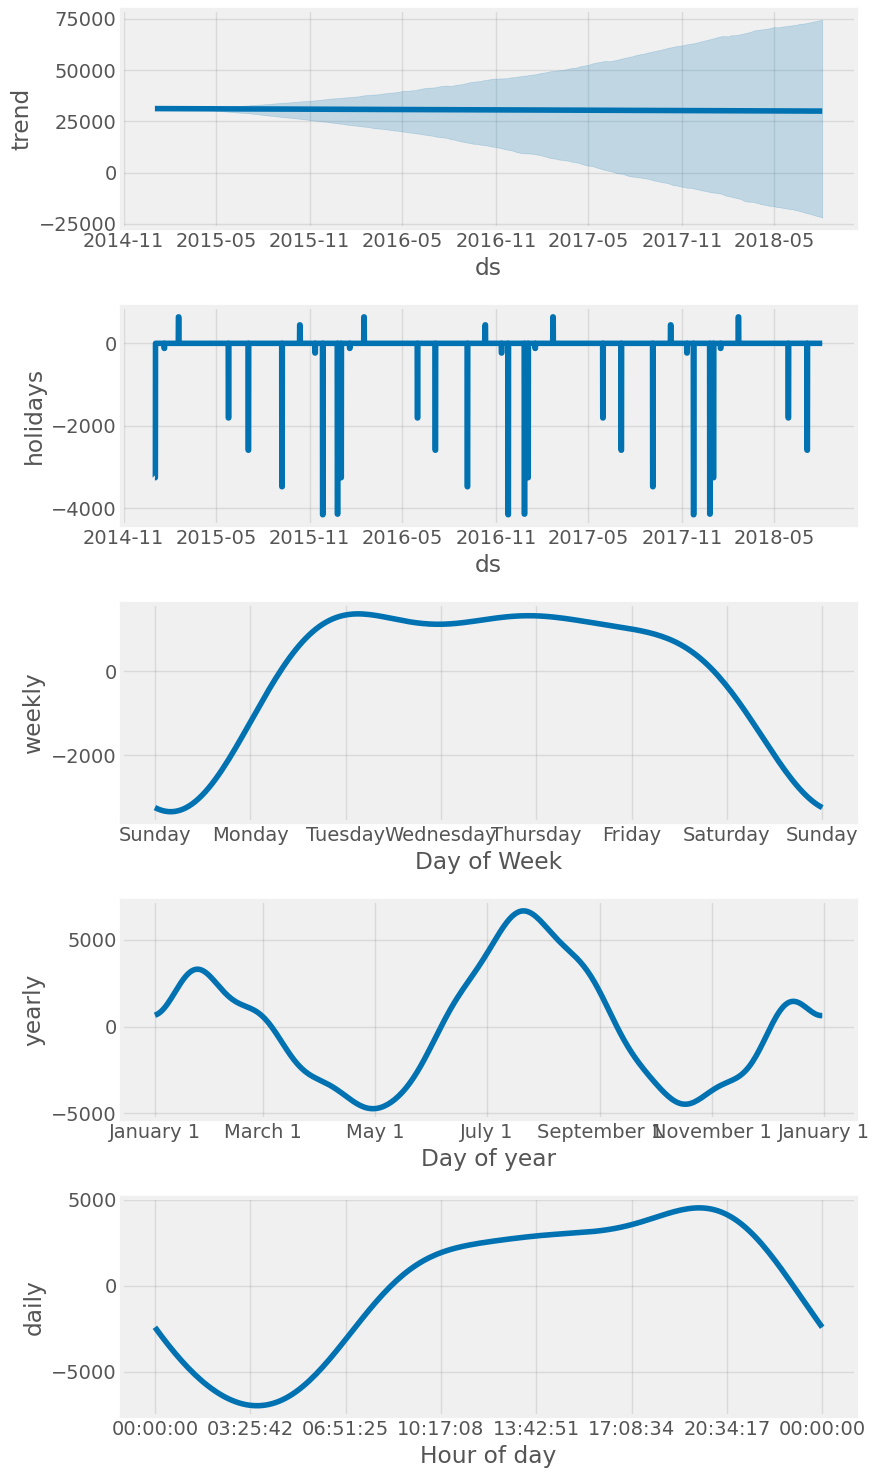

In [129]:
fig = model_with_holidays.plot_components(df_test_fcst_with_holidays)
plt.show()

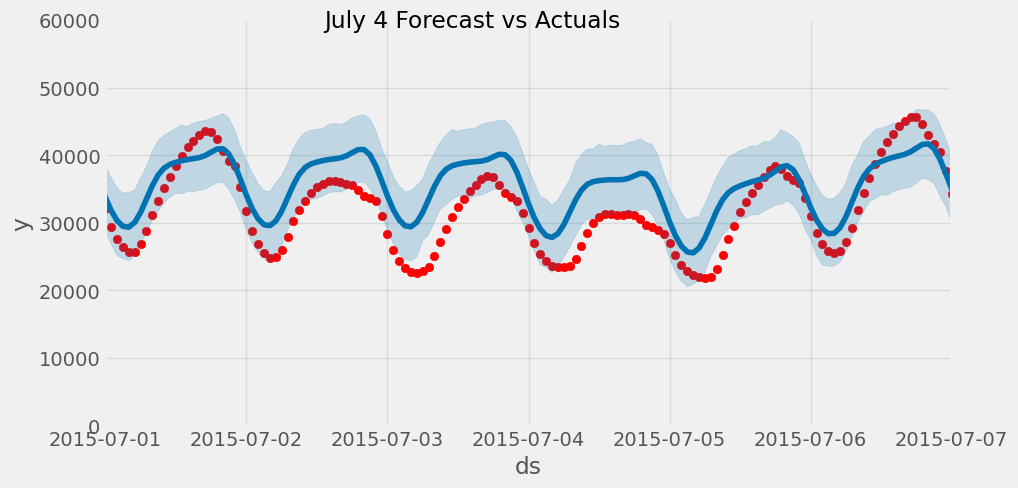

In [130]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test.index, df_test['PJME_MW'], color='r')
fig = model.plot(df_test_fcst, ax=ax)
ax.set_xbound(lower='07-01-2015',
              upper='07-07-2015')
ax.set_ylim(0, 60000)
plot = plt.suptitle('July 4 Forecast vs Actuals')
plt.show()

In [131]:
# root mean squared error
np.sqrt(mean_squared_error(y_true=df_test['PJME_MW'],
                           y_pred=df_test_fcst_with_holidays['yhat']))

6639.802219208022

In [132]:
mean_absolute_error(y_true=df_test['PJME_MW'],
                    y_pred=df_test_fcst_with_holidays['yhat'])

5200.950215632645

In [133]:
custom_mean_absolute_percentage_error(y_true=df_test['PJME_MW'],
                                      y_pred=df_test_fcst_with_holidays['yhat'])

16.56184356325992

In [134]:
# The same but needed to be multiplied by 100
mean_absolute_percentage_error(y_true=df_test['PJME_MW'],
                               y_pred=df_test_fcst_with_holidays['yhat'])

0.1656184356325992

The model with holidays works slightly worse - ToDo check holidays in the package and analyse holidays in the context of energy consumption

# Predict into the Future

Prophet has build it future prediction

In [135]:
future = model.make_future_dataframe(periods=365*24, freq='h', include_history=False)

In [136]:
forecast = model_with_holidays.predict(future)

In [137]:
forecast[['yhat']].head()

,yhat
0,25533.155856
1,24031.245054
2,23161.693677
3,23021.999361
4,23697.885060
